In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import squidpy as sq
import scanpy as sc
import os, shutil
from tqdm import tqdm
from transpa.eval_util import calc_corr, CalculateMeteics

import warnings
warnings.filterwarnings('ignore')

In [2]:
method_order = ["TransImp(Top50%)", "TransImpLR", "TransImpCls", "spaGE", "stPlus", "Tangram"]
color = ['#3274A1', '#3274A1', '#E1812C', '#3A923A', '#C03D3E', '#9372B2']

[Text(0, 0.5, 'Avg. Time (seconds)'),
 Text(0.5, 1.0, 'Average Training Time on 5-fold Cross Validataion')]

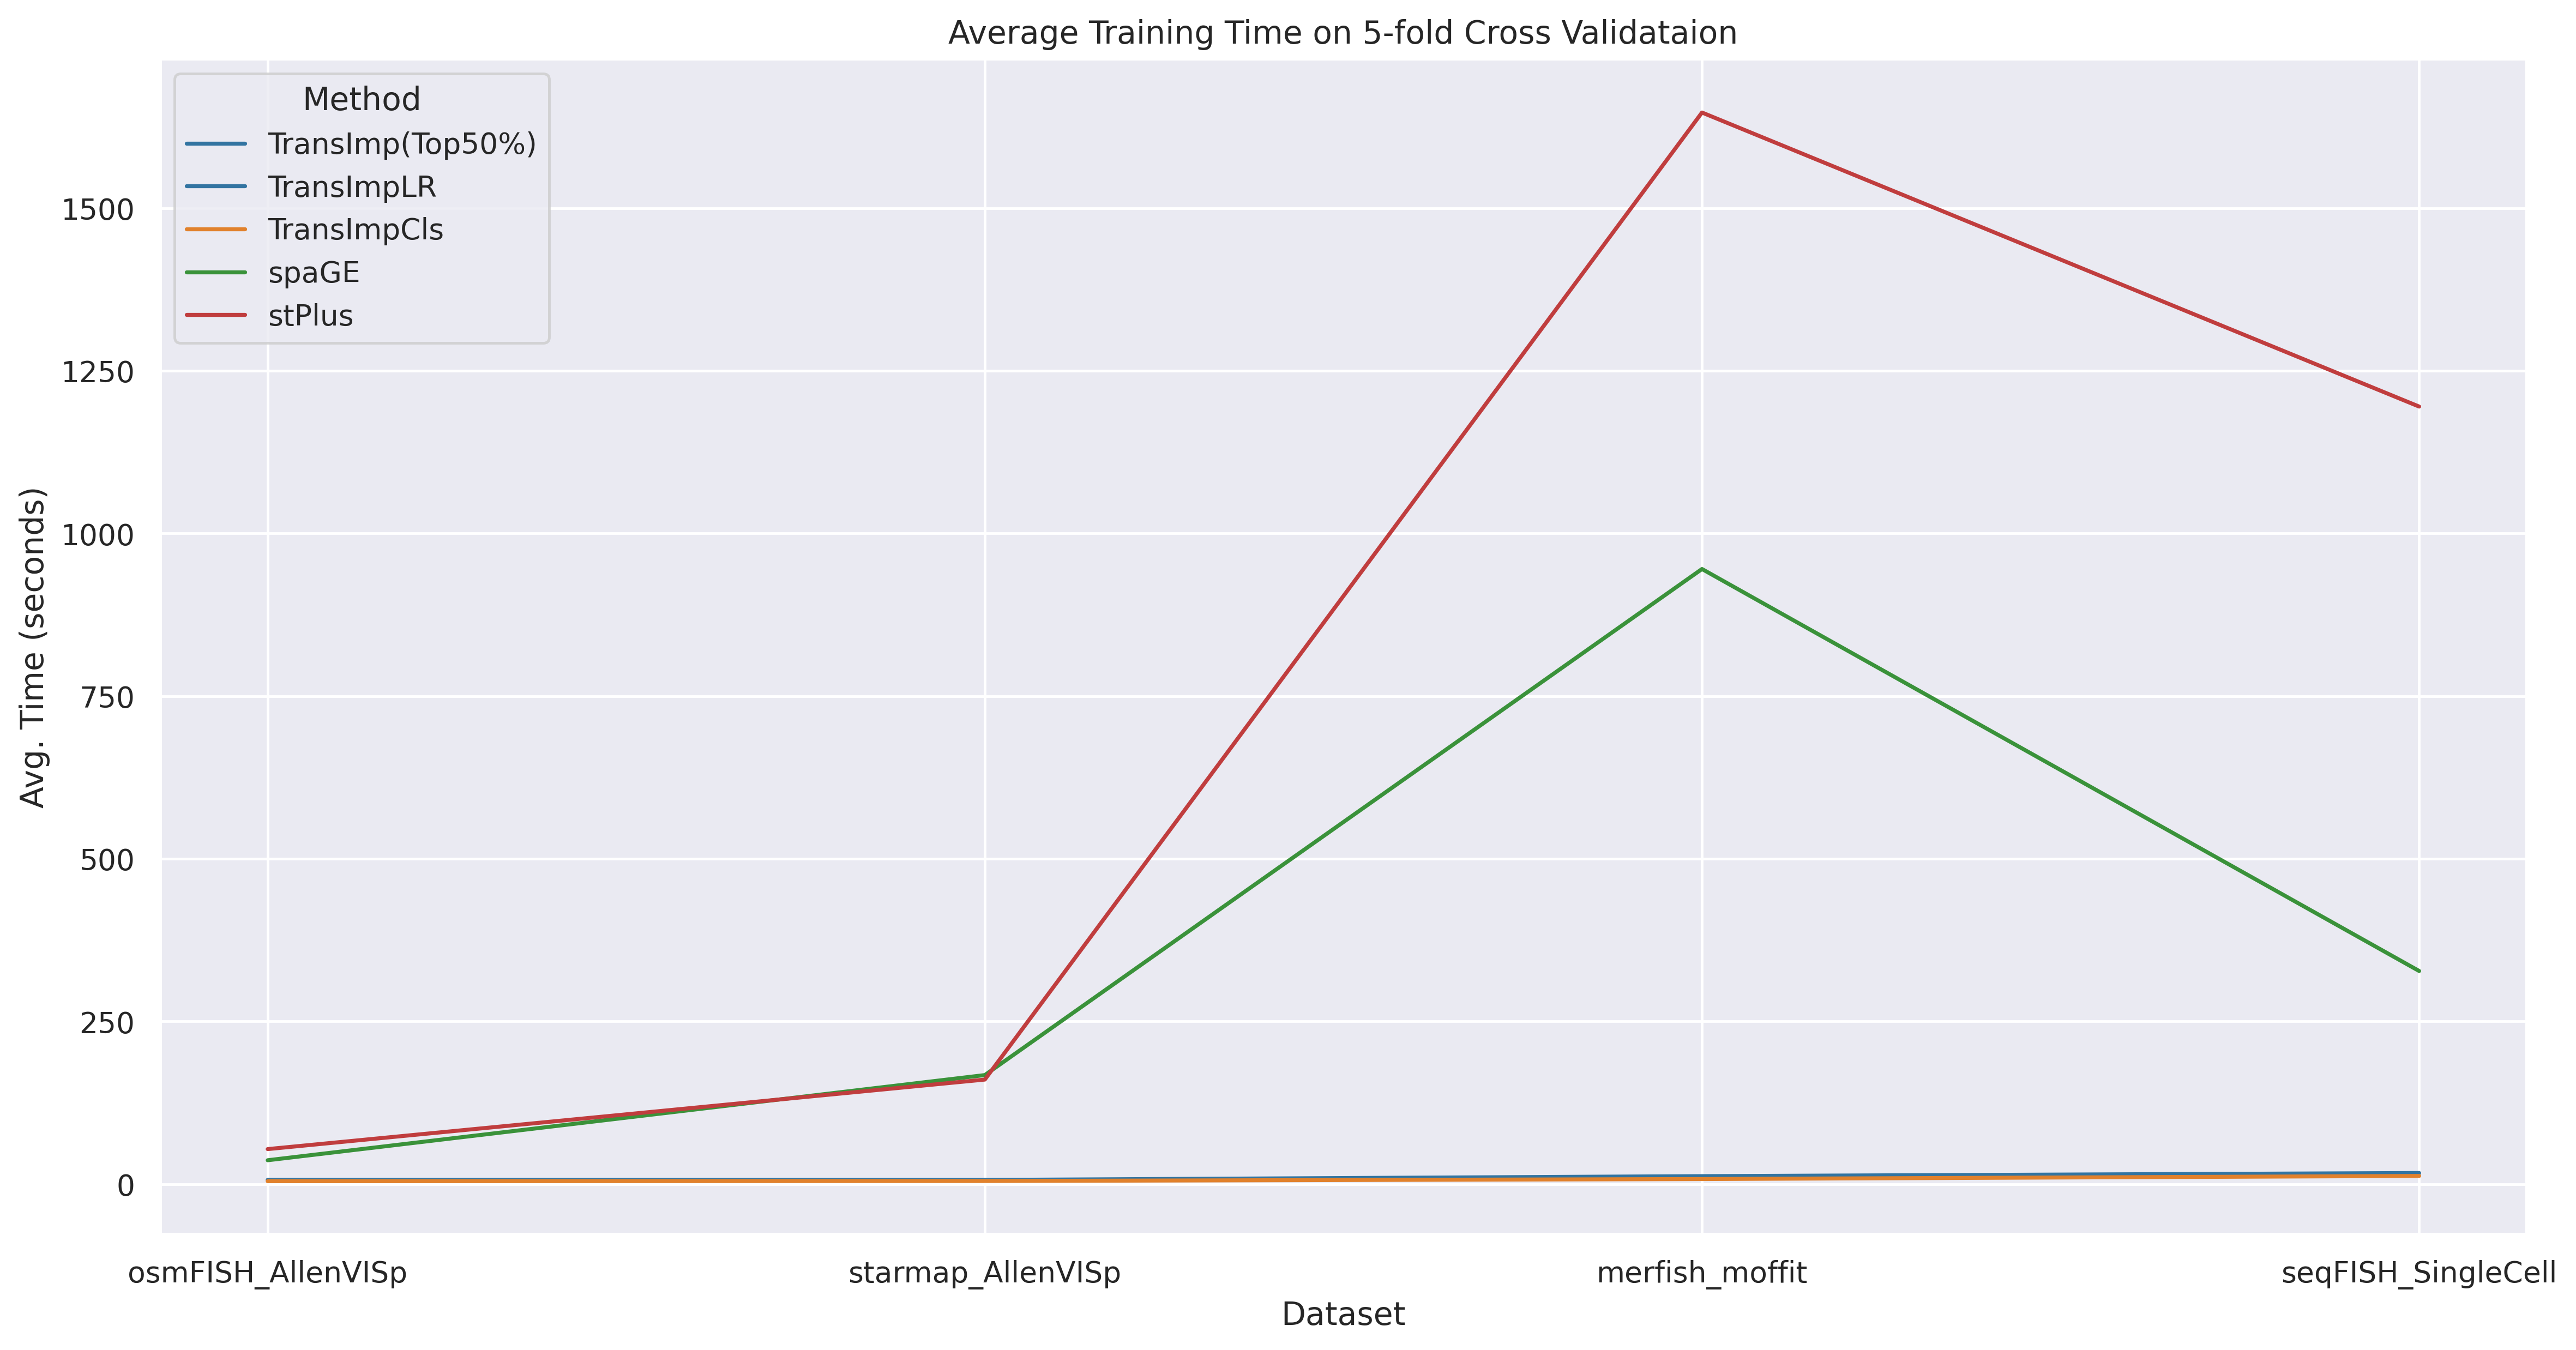

In [3]:
# efficiency
datasets = []
methods  = []
scores   = []
scale = []
with open('efficiency.out', 'r') as infile:
    for line in infile:
        if "Avg Runtime" in line:
            method = line.split(" ")[0]
            seconds = float(line.split(" ")[-1])
            if method == "TransImp":
                method = "TransImpLR"
            methods.append(method)
            scores.append(seconds)
        elif "spa shape" in line:
            dataset = line.split(",")[0]
            n_spots = int(line.split("X")[0].strip().split(" ")[-1])
            n_cells = int(line.split("X")[1].strip().split(" ")[-1])
            scale.append(n_spots + n_cells)
            datasets.append(dataset)
df = pd.DataFrame(np.array([datasets, methods, scores, scale]).T, columns=['Dataset', 'Method', 'Time', 'Size'])
df.Time = df.Time.astype('float')
sns.set(rc={'figure.figsize':(16,8), 'figure.dpi':350})
order = ["osmFISH_AllenVISp", "starmap_AllenVISp", "merfish_moffit", "seqFISH_SingleCell"]
df = df.iloc[np.concatenate([np.argwhere(df.Dataset.values == dat).flatten() for dat in order])]
df = df.query('Method !="TransImpSpa"')
df = df.query('Method !="TransImpClsSpa"')
sns.lineplot(data=df, x='Dataset', y='Time', hue='Method', hue_order=method_order[:5], palette=color[:5], sort=False).set(
    ylabel="Avg. Time (seconds)",
    title="Average Training Time on 5-fold Cross Validataion"
)


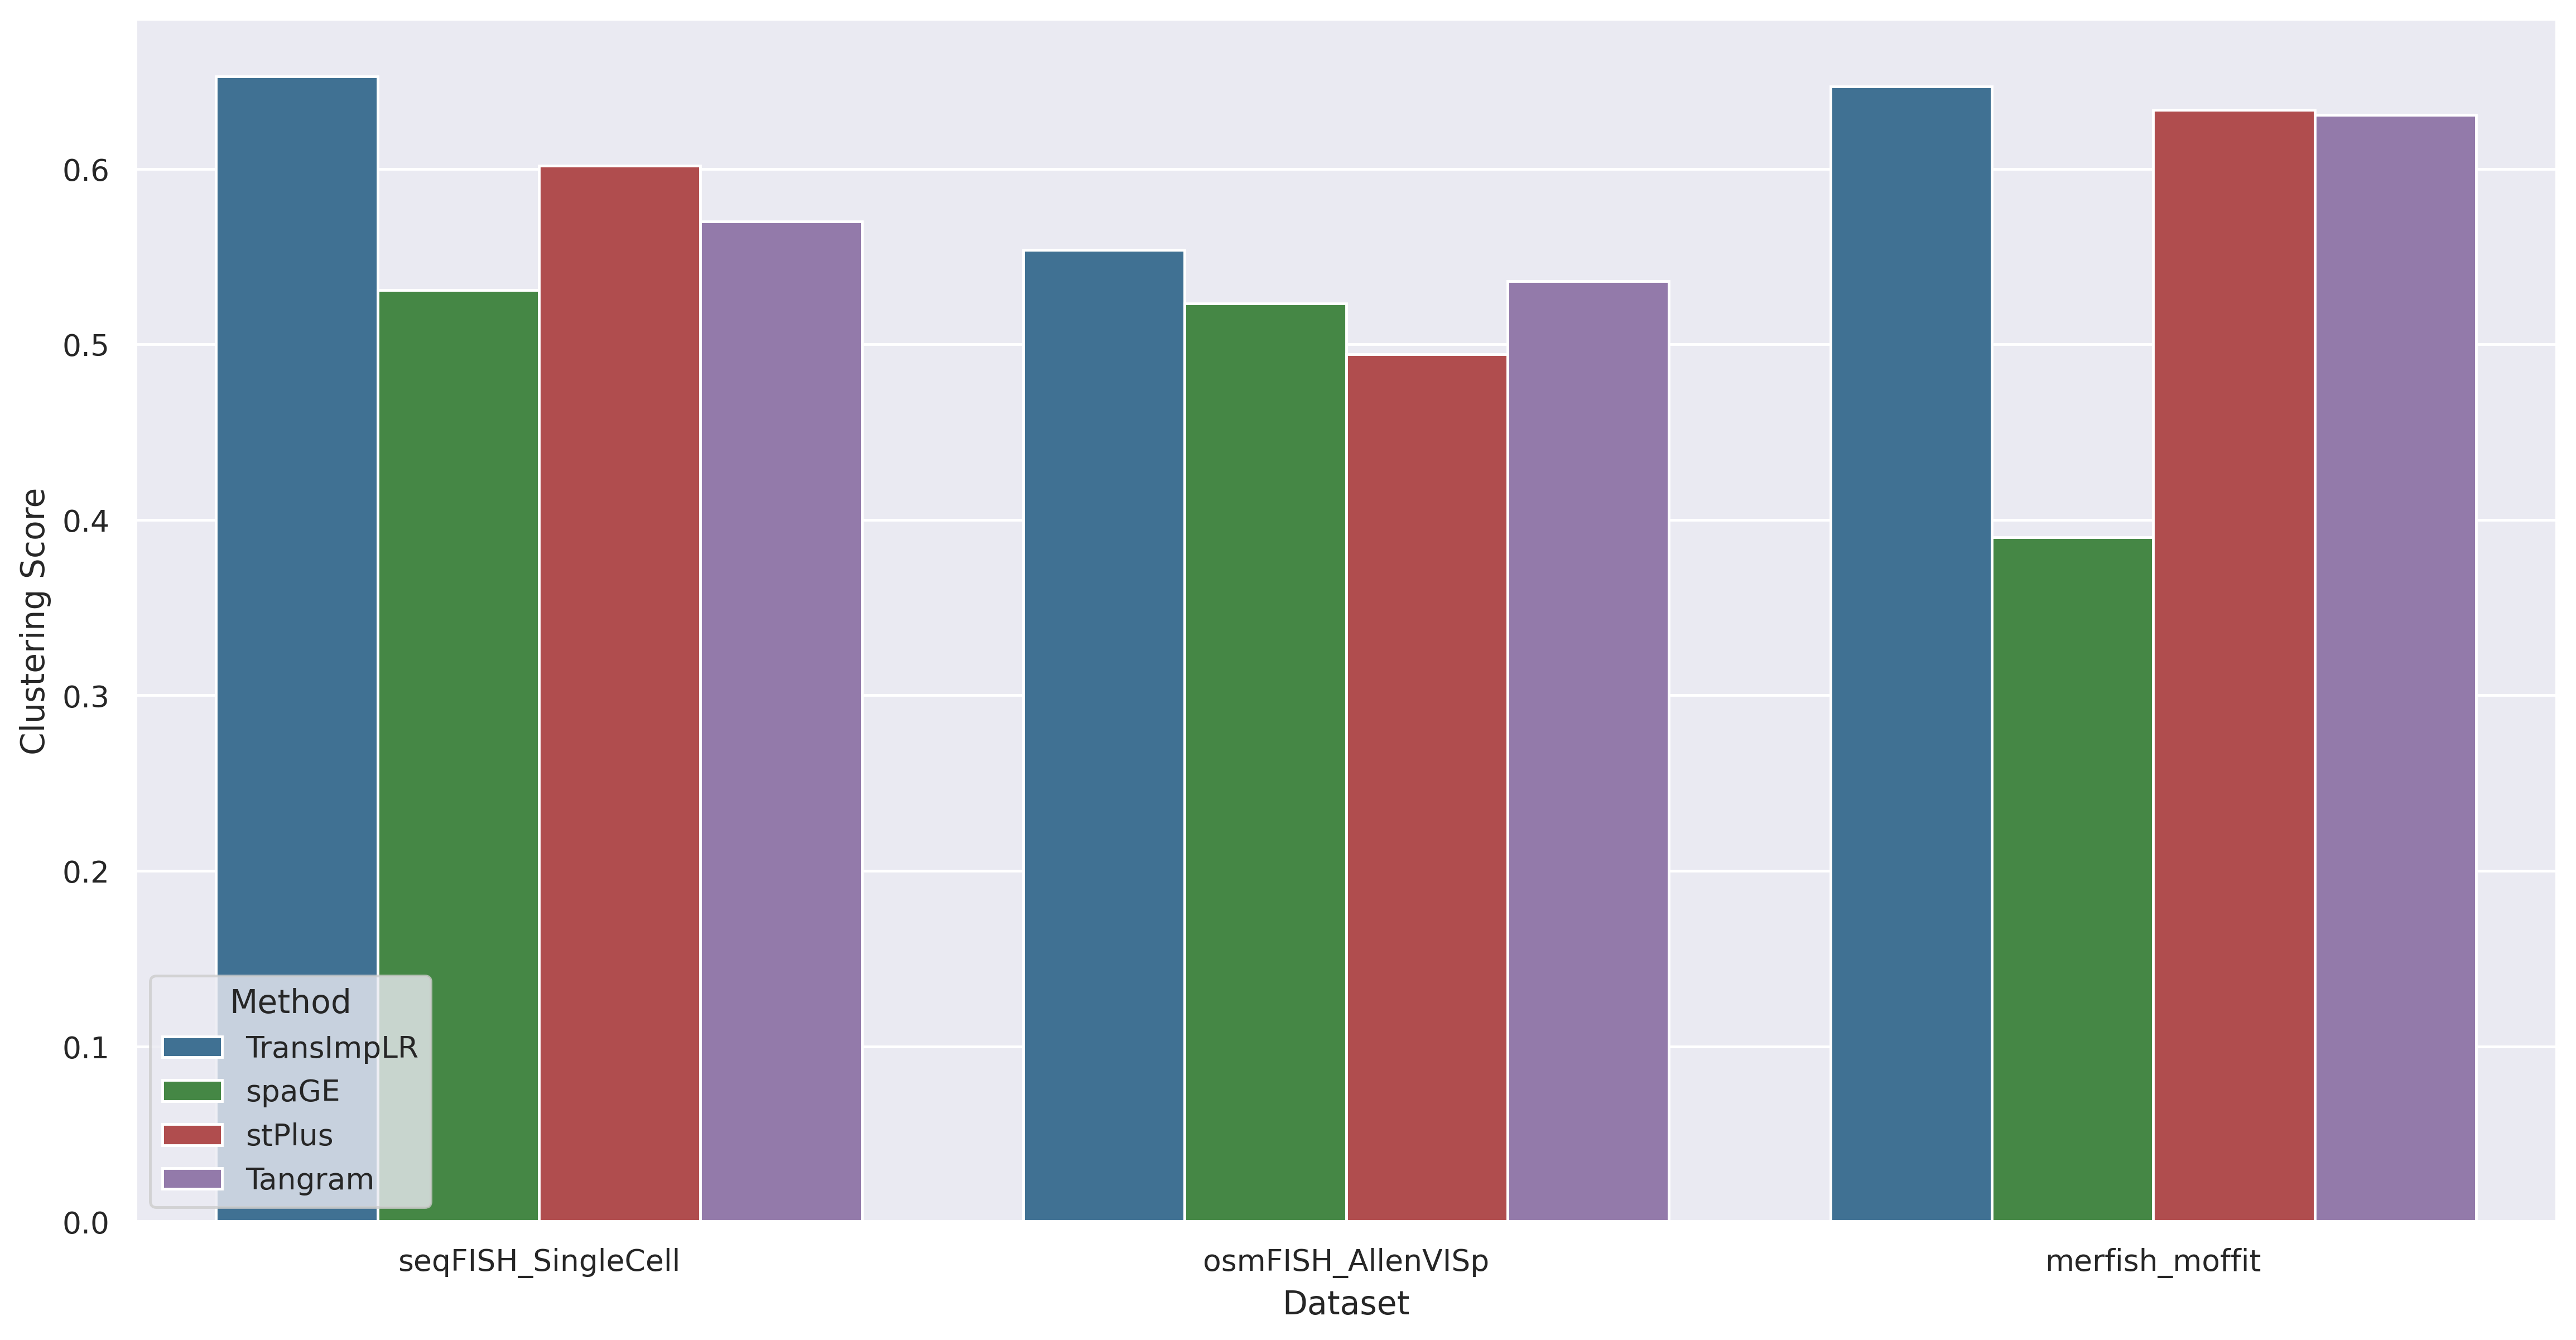

In [4]:
_method_order = ["TransImpLR", "spaGE", "stPlus", "Tangram"]
_color = ['#3274A1', '#3A923A', '#C03D3E', '#9372B2']
df_res = None
for file in os.listdir('../../output/clustering/'):
    if len(file.split(".")[0].split('_')) != 2: continue
    spa, rna = file.split(".")[0].split('_')
    if spa not in {"merfish", "osmFISH", "seqFISH", "starmap"}: continue
    # method = method if not method in method_mapping else method_mapping[method]
    df = pd.read_csv(os.path.join('../../output/clustering', file), index_col=0)
    _df = pd.DataFrame()
    sel = np.ones(df.shape[1], dtype=bool)
    sel = df.columns != 'TransImpCls'
    _df['Clustering Score'] = np.mean(df.values, axis=0)[sel]
    _df['Method'] = df.columns[sel]
    _df['Dataset'] = f"{spa}_{rna}"
    if not df_res is None:
        df_res = pd.concat([df_res, _df])
    else:
        df_res = _df

dataset_order = ["seqFISH_SingleCell", "osmFISH_AllenVISp", "merfish_moffit"]
df_res = df_res.iloc[np.concatenate([np.argwhere(df_res.Dataset.values == dat).flatten() for dat in dataset_order])]
sns.set(rc={'figure.figsize':(16,8), 'figure.dpi':350})


sns.barplot(data=df_res, x='Dataset', order=dataset_order, y='Clustering Score', hue='Method', hue_order=_method_order, palette=_color)
plt.legend(loc='lower left', title='Method')

In [5]:
methods, datasets = [], []
correlations = []
df_spas = {file.split('_')[0].lower():pd.read_csv(os.path.join('../../output', file), index_col=0) for file in os.listdir('../../output') if file.endswith('raw.csv')}

for file in os.listdir('../../output'):
    if file.split('_')[-1].split('.')[0] not in {'spaGE', 'TransImpLR', 'stPlus', 'Tangram', 'TransImpCls'}: continue
    if len(file.split(".")[0].split('_')) != 3: continue
    spa, rna, method = file.split(".")[0].split('_')
    if spa not in {"merfish", "osmFISH", "seqFISH", "starmap"}: continue
    df_res = pd.read_csv(os.path.join('../../output',file), index_col=0)
    
    corrs = calc_corr(df_spas[spa.lower()], df_res, df_res.columns)
    datasets = datasets + [f'{spa}_{rna}'] * len(corrs)
    methods = methods  + [method] * len(corrs)
    correlations.extend(corrs)
    print(file)
    
    if method == 'TransImpLR':
        df_uncertainty = pd.read_csv(f"../../output/performance_uncertainty/{spa.lower()}.csv", index_col=0)
        better_genes = df_uncertainty.query(f'perf_var < {np.quantile(df_uncertainty.perf_var, 0.5)}').gene.values
        corrs = calc_corr(df_spas[spa.lower()], df_res, better_genes)
        datasets = datasets + [f'{spa}_{rna}'] * len(corrs)
        methods = methods  + ["TransImp(Top50%)"] * len(corrs)
        correlations.extend(corrs)
        
    
    
df_stats = pd.DataFrame(columns=['method', 'dataset', 'cos_sim'])
df_stats.method = methods
df_stats.dataset = datasets
df_stats.cos_sim = correlations
df_stats

seqFISH_SingleCell_TransImpCls.csv
starmap_AllenVISp_TransImpCls.csv
starmap_AllenVISp_TransImpLR.csv
merfish_moffit_spaGE.csv
seqFISH_SingleCell_stPlus.csv
merfish_moffit_stPlus.csv
osmFISH_AllenVISp_TransImpCls.csv
seqFISH_SingleCell_TransImpLR.csv
osmFISH_AllenVISp_Tangram.csv
starmap_AllenVISp_stPlus.csv
starmap_AllenVISp_spaGE.csv
seqFISH_SingleCell_Tangram.csv
merfish_moffit_TransImpLR.csv
merfish_moffit_TransImpCls.csv
starmap_AllenVISp_Tangram.csv
osmFISH_AllenVISp_TransImpLR.csv
osmFISH_AllenVISp_spaGE.csv
merfish_moffit_Tangram.csv
seqFISH_SingleCell_spaGE.csv
osmFISH_AllenVISp_stPlus.csv


,method,dataset,cos_sim
0,TransImpCls,seqFISH_SingleCell,0.383564
1,TransImpCls,seqFISH_SingleCell,0.572905
2,TransImpCls,seqFISH_SingleCell,0.442397
3,TransImpCls,seqFISH_SingleCell,0.448224
4,TransImpCls,seqFISH_SingleCell,0.310701
...,...,...,...
8414,stPlus,osmFISH_AllenVISp,0.855376
8415,stPlus,osmFISH_AllenVISp,0.760732
8416,stPlus,osmFISH_AllenVISp,0.587952
8417,stPlus,osmFISH_AllenVISp,0.602189


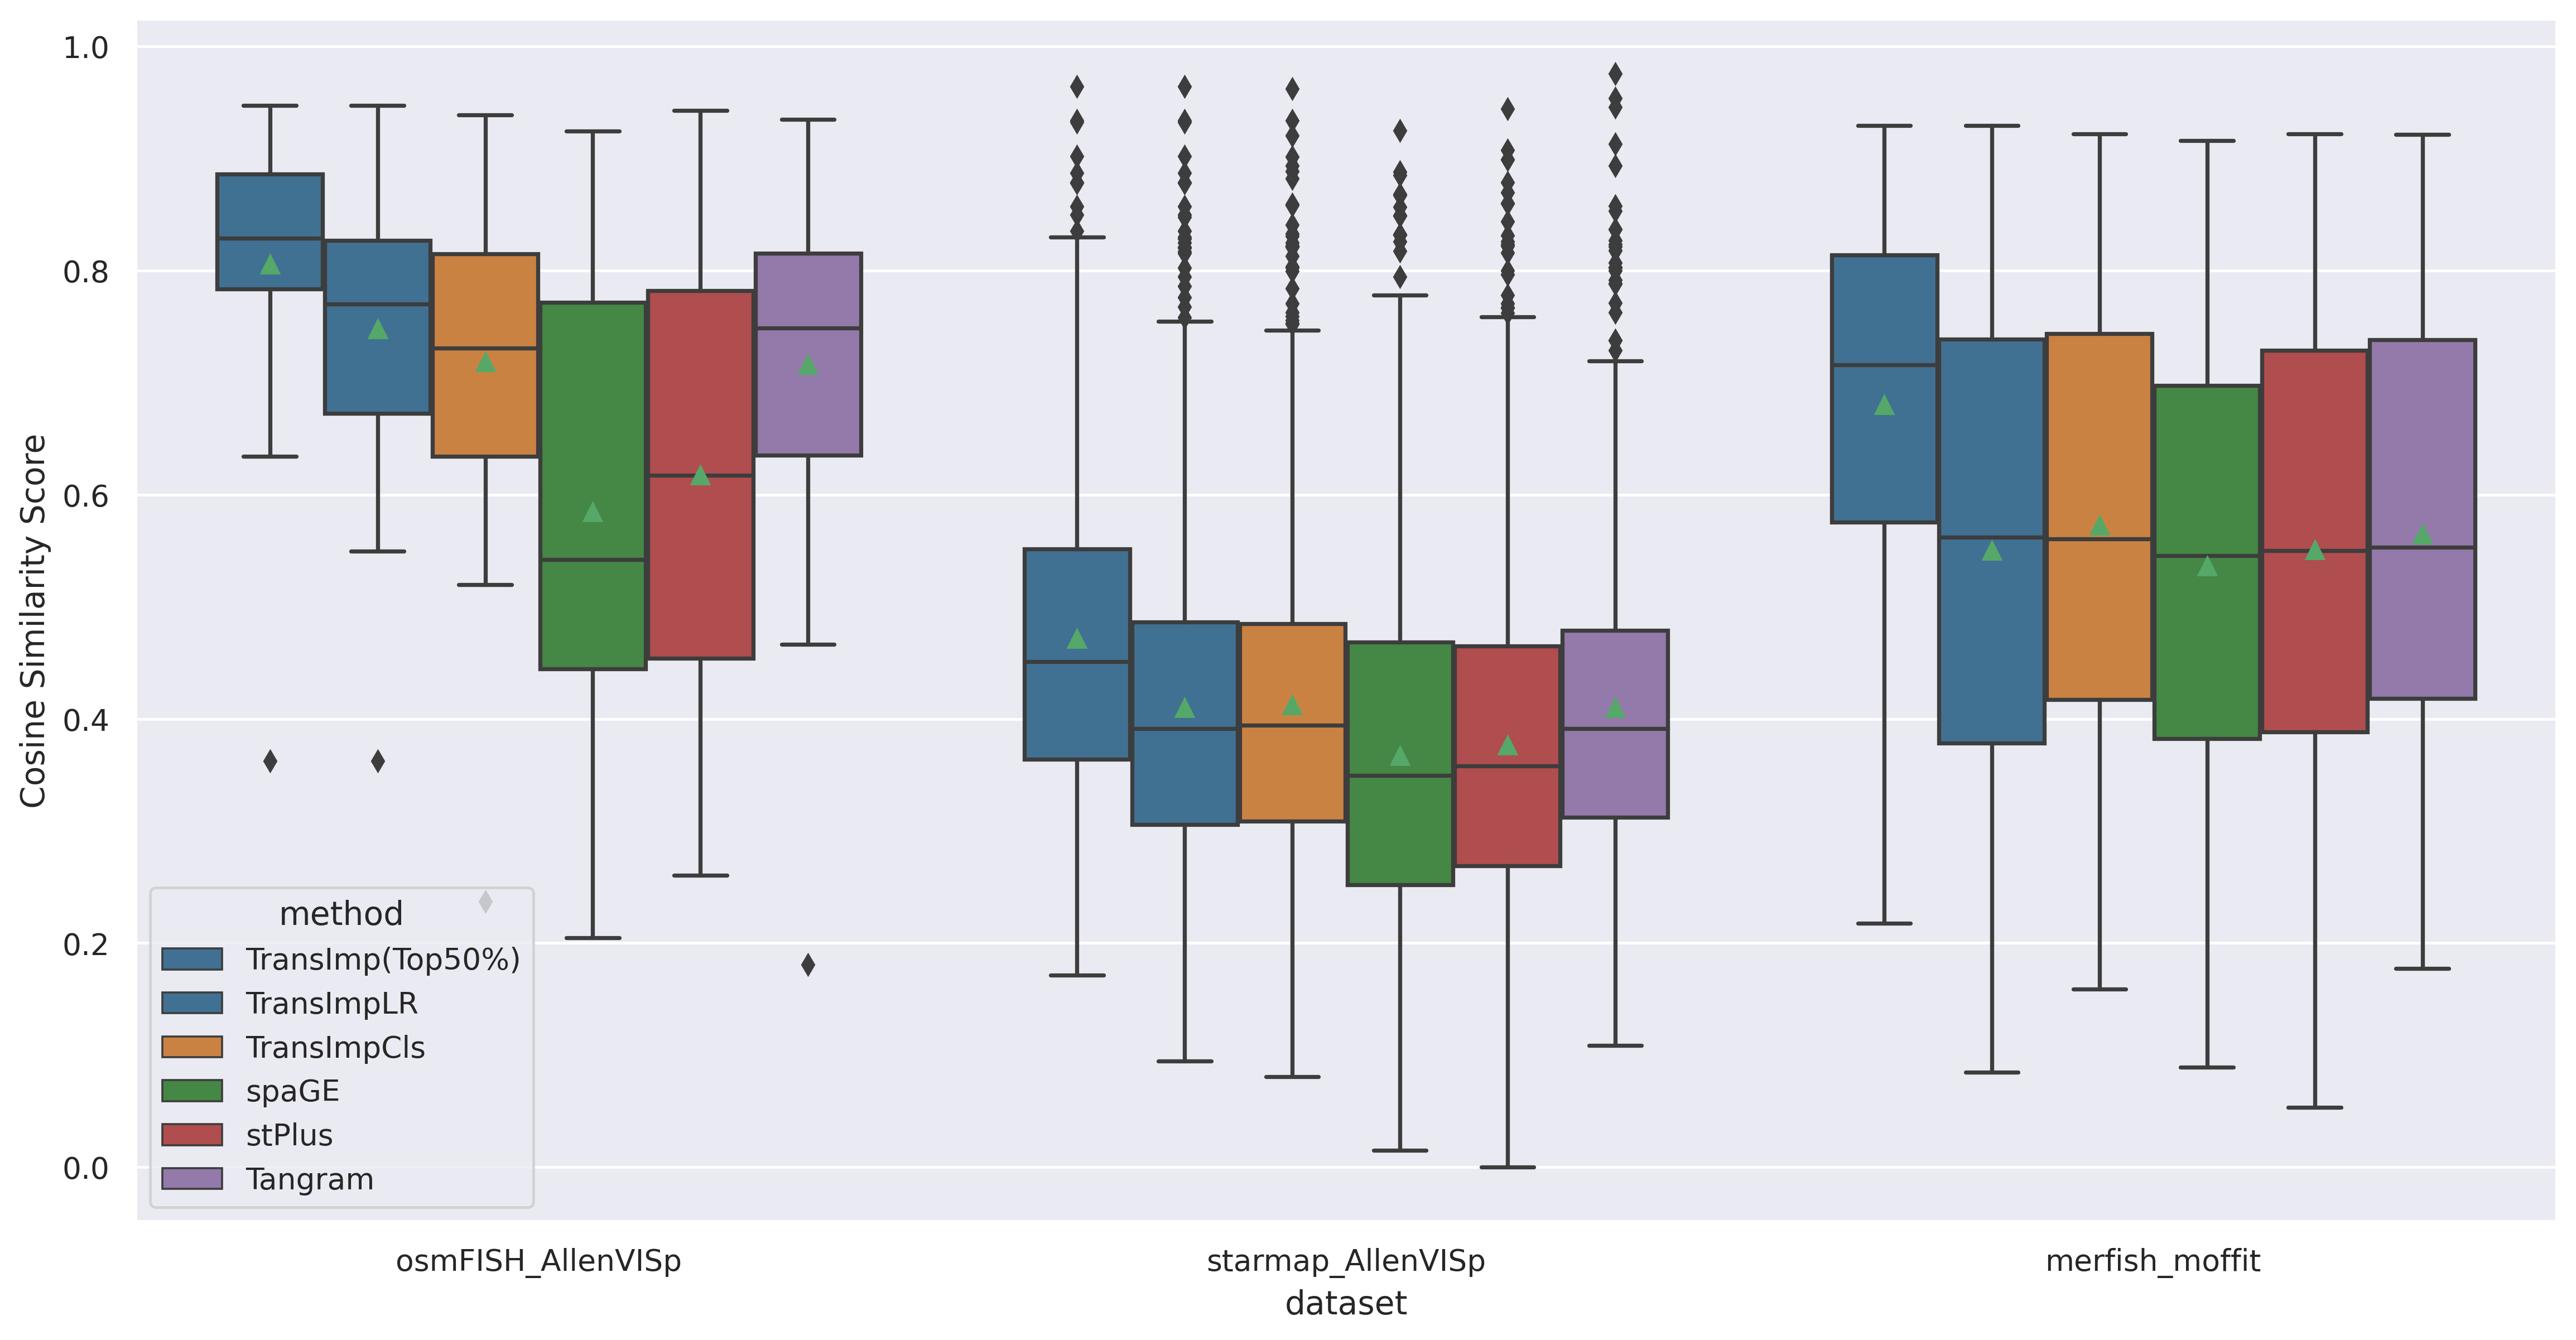

In [6]:
sns.set(rc={'figure.figsize':(16,8), 'figure.dpi':350})
data_order = ["osmFISH_AllenVISp", "starmap_AllenVISp", "merfish_moffit"]
# method_order = ['spaGE', 'stPlus', 'Tangram', "transImpCls", "transImpClsSpa", "transImpute", "transImpSpa"]
df_res = df_stats.iloc[np.concatenate([np.argwhere(df_stats.dataset.values == dat).flatten() for dat in data_order])]
ax = sns.boxplot(x="dataset", y="cos_sim", hue="method",order=data_order, hue_order=method_order[:6],
                 data=df_res, palette=color[:6], showmeans=True).set(
    ylabel='Cosine Similarity Score'
)